#### **Import packages**

In [1]:
# Install seaborn
%pip install seaborn

# Install missingno
%pip install missingno

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 8.0 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
sns.set(font_scale = 1.4)
sns.set_style("ticks")
sns.set_palette("winter")

blue_color = "#0000FF"
insight_color = "#00FFFF"

#### **Load tables (Spark)**

In [4]:
# Sales
from deltalake import DeltaTable, write_deltalake
table_path = 'abfss://Projeto_II@onelake.dfs.fabric.microsoft.com/Projeto_II_Gold_.Lakehouse/Tables/Projeto_II_Gold_/fact_sales' 
storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true"}
sales_spark = DeltaTable(table_path, storage_options=storage_options)

In [5]:
# Products
from deltalake import DeltaTable, write_deltalake
table_path = 'abfss://Projeto_II@onelake.dfs.fabric.microsoft.com/Projeto_II_Gold_.Lakehouse/Tables/Projeto_II_Gold_/dim_product' 
storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true"}
products_spark = DeltaTable(table_path, storage_options=storage_options)


In [6]:
# Stores
from deltalake import DeltaTable, write_deltalake
table_path = 'abfss://Projeto_II@onelake.dfs.fabric.microsoft.com/Projeto_II_Gold_.Lakehouse/Tables/Projeto_II_Gold_/dim_stores' 
storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true"}
stores_spark = DeltaTable(table_path, storage_options=storage_options)

In [7]:
# Date
from deltalake import DeltaTable, write_deltalake
table_path = 'abfss://Projeto_II@onelake.dfs.fabric.microsoft.com/Projeto_II_Gold_.Lakehouse/Tables/Projeto_II_Gold_/dim_date' 
storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true"}
date_spark = DeltaTable(table_path, storage_options=storage_options)

#### **Convert to Pandas**

In [8]:
sales = sales_spark.to_pandas()
products = products_spark.to_pandas()
stores = stores_spark.to_pandas()
date = date_spark.to_pandas()

In [9]:
# Date
date["full_date"] = pd.to_datetime(date["full_date"], format="%Y-%m-%d")

date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033 entries, 0 to 1032
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_id            1033 non-null   int32         
 1   full_date          1033 non-null   datetime64[ns]
 2   year               1033 non-null   int32         
 3   month              1033 non-null   int32         
 4   day                1033 non-null   int32         
 5   day_of_week_num    1033 non-null   int32         
 6   day_of_week_short  1033 non-null   object        
 7   day_of_week_long   1033 non-null   object        
 8   week_of_year       1033 non-null   int32         
 9   quarter            1033 non-null   int32         
 10  month_name_long    1033 non-null   object        
 11  month_name_short   1033 non-null   object        
 12  is_weekend         1033 non-null   bool          
 13  is_holiday         1033 non-null   bool          
dtypes: bool(

#### **Sales dataset**

##### **Inspect**

In [10]:
sales.info()
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8886058 entries, 0 to 8886057
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_id                int32  
 1   store_id               object 
 2   product_id             object 
 3   sales                  float64
 4   revenue                float64
 5   stock                  float64
 6   price                  float64
 7   promo_type_1           object 
 8   promo_bin_1            object 
 9   promo_type_2           object 
 10  promo_bin_2            object 
 11  promo_discount_2       float64
 12  promo_discount_type_2  object 
dtypes: float64(5), int32(1), object(7)
memory usage: 847.4+ MB


,date_id,store_id,product_id,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2
0,20170811,S0002,P0005,0.0,0.00,10.0,33.90,PR14,NA,PR03,NA,0.0,NA
1,20170811,S0002,P0015,0.0,0.00,8.0,2.85,PR10,low,PR03,NA,0.0,NA
2,20170811,S0002,P0017,10.0,11.76,22.0,1.45,PR10,verylow,PR03,NA,0.0,NA
3,20170811,S0002,P0024,0.0,0.00,18.0,1.90,PR14,NA,PR03,NA,0.0,NA
4,20170811,S0002,P0035,2.0,7.87,7.0,4.25,PR14,NA,PR03,NA,0.0,NA


##### **date_id**

In [11]:
# Join
sales = sales.merge(
    date[["full_date", "date_id"]], 
    how = "left",
    on = "date_id")

# Describe
sales["full_date"].describe()

count                          8886058
mean     2018-07-10 00:51:08.502319104
min                2017-01-02 00:00:00
25%                2017-11-10 00:00:00
50%                2018-07-28 00:00:00
75%                2019-03-19 00:00:00
max                2019-10-31 00:00:00
Name: full_date, dtype: object

###### **Notes**

The timeframe of all sales is between 2017-01-02 and 2019-10-31.

##### **store_id**

In [12]:
# Missing values
print(sales["store_id"].isna().sum())

# Nº of stores
print(sales["store_id"].nunique())

0
63


###### **Notes**

- There are 63 stores.

##### **product_id**

In [13]:
# Missing values
print(sales["product_id"].isna().sum())

# Nº of total products
print(sales["product_id"].nunique())

0
615


###### **Notes**

- There are 615 products.

##### **sales**

In [14]:
sales["sales"].describe().round(2)

count    8886058.00
mean           0.46
std           20.93
min            0.00
25%            0.00
50%            0.00
75%            0.00
max        43301.00
Name: sales, dtype: float64

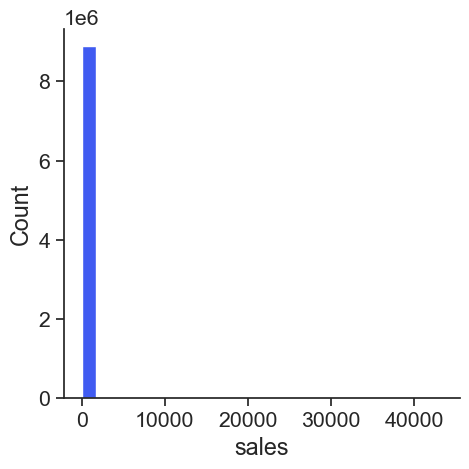

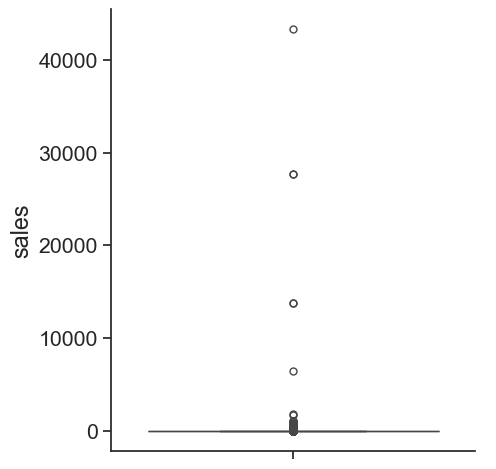

In [15]:
sns.displot(
    data = sales,
    x = "sales",
    kind = "hist")
plt.show()

sns.catplot(
    data = sales,
    y = "sales",
    kind = "box")
plt.show()

###### **Notes**

- The range of daily sales is between 0 and 43301.
- The mean is 0.46 daily sales.
- The 75th percentile of all sales is 0.
    - Most likely, there are a lot of stores closed over time and in some specific periods. 
    - In addition, it can also mean lack of stock.

##### **revenue**

In [16]:
sales["revenue"].describe().round(2)

count    8886058.00
mean           2.21
std           53.14
min            0.00
25%            0.00
50%            0.00
75%            0.00
max        84197.96
Name: revenue, dtype: float64

###### **Notes**

- The range of daily revenue is between 0 and 84197.26.
- The daily mean is 2.21.
- The 75th percentile of revenue is 0. 
    - Most likely, there are a lot of stores closed over time and in some specific periods. 
    - In addition, it can also mean lack of stock.

##### **stock**

In [17]:
# Missing values 
print(sales["stock"].isna().sum())

# Describe
sales["stock"].describe().round(2)

0


count    8886058.00
mean          15.46
std           36.99
min            0.00
25%            4.00
50%            8.00
75%           16.00
max         4655.00
Name: stock, dtype: float64

##### **price**

In [18]:
# Missing values
print(sales["price"].isna().sum())

sales["price"].describe().round(2)

0


count    8886058.00
mean          15.67
std           32.62
min            0.01
25%            3.50
50%            8.00
75%           16.90
max         1599.00
Name: price, dtype: float64

##### **promo**

In [19]:
# Missing Values
print(sales["promo_type_1"].isna().sum())
print(sales["promo_type_2"].isna().sum())
print(sales["promo_bin_1"].isna().sum())
print(sales["promo_bin_2"].isna().sum())

# promo_type
print(sales["promo_type_1"].unique())
print(sales["promo_type_2"].unique())
print(sales["promo_discount_type_2"].unique())  

# promo_bin
print(sales["promo_bin_1"].unique())
print(sales["promo_bin_2"].unique())

0
0
0
0
['PR14' 'PR10' 'PR03' 'PR06' 'PR07' 'PR05' 'PR09' 'PR01' 'PR17' 'PR11'
 'PR12' 'PR08' 'PR18' 'PR13' 'PR16' 'PR04' 'PR15']
['PR03' 'PR02' 'PR01' 'PR04']
['NA' 'PR02' 'PR01' 'PR03' 'PR04']
['NA' 'low' 'verylow' 'veryhigh' 'high' 'moderate']
['NA' 'verylow' 'high' 'veryhigh']


In [20]:
# promo_discount
print(sales["promo_discount_2"].describe().round(2))
print(sales["promo_discount_type_2"].unique())

# Missing Values
print(sales["promo_discount_2"].isna().sum())
print(sales["promo_discount_type_2"].isna().sum())

count    8886058.00
mean           0.04
std            1.22
min            0.00
25%            0.00
50%            0.00
75%            0.00
max           50.00
Name: promo_discount_2, dtype: float64
['NA' 'PR02' 'PR01' 'PR03' 'PR04']
0
0


###### **Notes**

- What is the difference between promo_type_1 and promo_type_2? 
- What is promo_discount_type_2?
- Are there relevant for the business? 
- promo_bin looks subjective. Should we remove it? 

#### **Product Dataset**

##### **Inspect**

In [21]:
products.info()
products.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      699 non-null    object 
 1   product_length  699 non-null    float64
 2   product_depth   699 non-null    float64
 3   product_width   699 non-null    float64
 4   cluster_id      699 non-null    object 
 5   hierarchy1_id   699 non-null    object 
 6   hierarchy2_id   699 non-null    object 
 7   hierarchy3_id   699 non-null    object 
 8   hierarchy4_id   699 non-null    object 
 9   hierarchy5_id   699 non-null    object 
dtypes: float64(3), object(7)
memory usage: 54.7+ KB


,product_id,product_length,product_depth,product_width,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id
0,P0000,5.0,20.0,12.0,unknown_cluster,H00,H0004,H000401,H00040105,H0004010534
1,P0001,13.5,22.0,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006
2,P0002,22.0,40.0,22.0,cluster_0,H03,H0315,H031508,H03150800,H0315080028
3,P0004,2.0,13.0,4.0,cluster_3,H03,H0314,H031405,H03140500,H0314050003
4,P0005,16.0,30.0,16.0,cluster_9,H03,H0312,H031211,H03121109,H0312110917


##### **product_id**

In [22]:
# Nº of products
products["product_id"].nunique()

699

###### **Notes**

- There are 699 products.

##### **product_length, depth, width**

In [23]:
# Describe
products[["product_length", "product_depth", "product_width"]].describe().round(2)

,product_length,product_depth,product_width
count,699.00,699.00,699.00
mean,7.05,18.04,13.15
std,8.48,14.37,10.22
min,0.00,0.00,0.00
25%,3.00,10.00,7.00
50%,5.00,16.80,10.10
75%,7.90,23.00,16.00
max,100.00,165.00,100.00


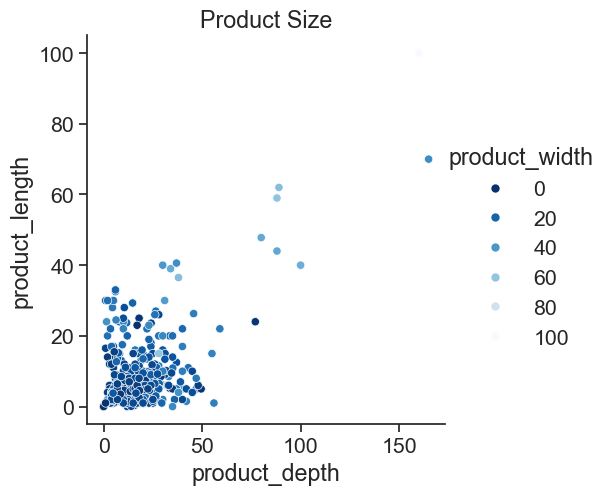

In [24]:
# Visualization
sns.relplot(
    data = products,
    y = "product_length",
    x = "product_depth",
    hue = "product_width",
    palette = "Blues_r")
plt.title("Product Size")
plt.show()

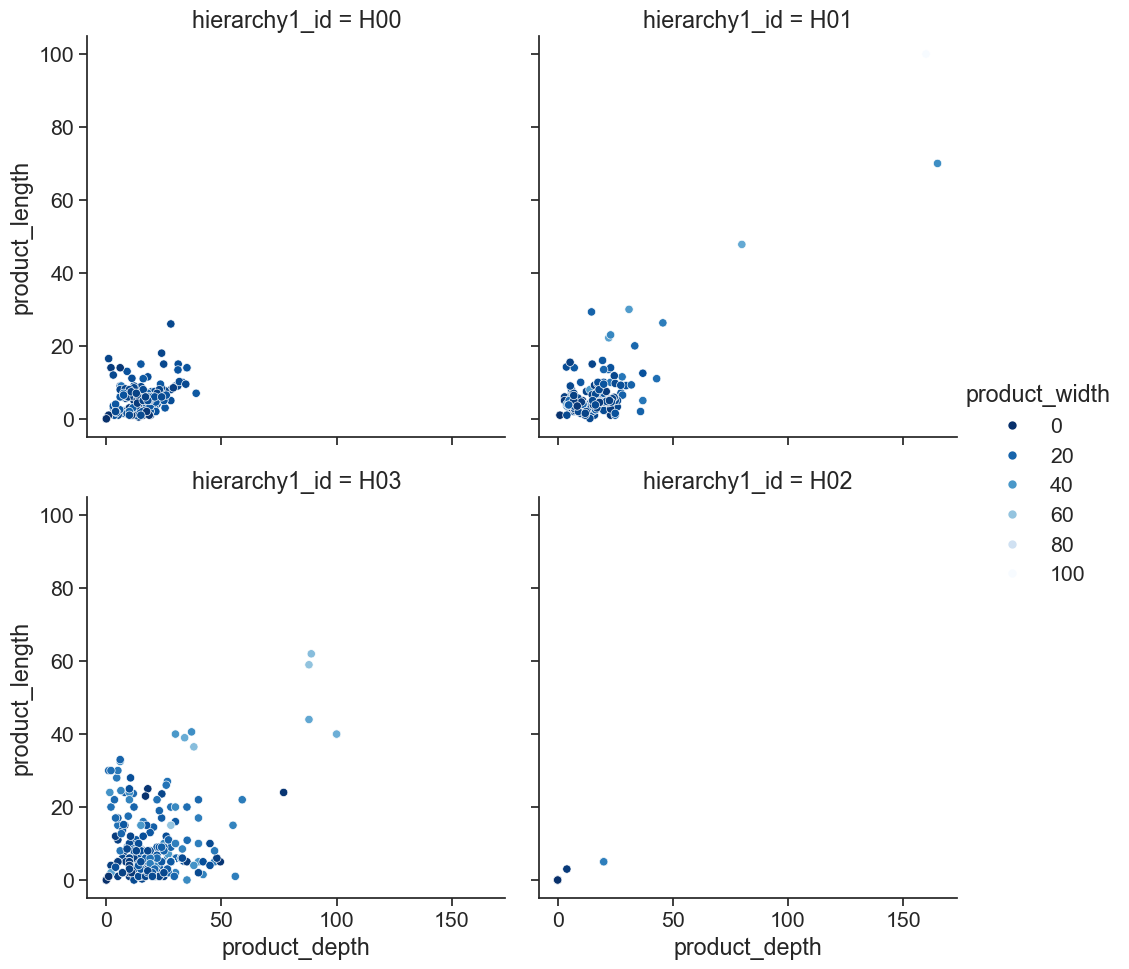

In [25]:
# Visualization
sns.relplot(
    data = products,
    y = "product_length",
    x = "product_depth",
    hue = "product_width",
    col = "hierarchy1_id",
    col_wrap = 2,
    palette = "Blues_r")
plt.show()

In [26]:
print(products[products["product_length"] == 0].describe().round(2))

print(products[products["product_depth"] == 0].describe().round(2))

print(products[products["product_length"] == 0].head())

       product_length  product_depth  product_width
count            19.0          19.00          19.00
mean              0.0           2.47           2.37
std               0.0           8.34           8.23
min               0.0           0.00           0.00
25%               0.0           0.00           0.00
50%               0.0           0.00           0.00
75%               0.0           0.00           0.00
max               0.0          35.00          35.00
       product_length  product_depth  product_width
count            17.0           17.0           17.0
mean              0.0            0.0            0.0
std               0.0            0.0            0.0
min               0.0            0.0            0.0
25%               0.0            0.0            0.0
50%               0.0            0.0            0.0
75%               0.0            0.0            0.0
max               0.0            0.0            0.0
    product_id  product_length  product_depth  product_width    

###### **Notes**

- There are products with length, depth and width as 0 due to imputation in previous steps.

##### **cluster_id**

In [27]:
# Clusters
products["cluster_id"].unique()

array(['unknown_cluster', 'cluster_5', 'cluster_0', 'cluster_3',
       'cluster_9', 'cluster_4', 'cluster_6', 'cluster_1', 'cluster_7',
       'cluster_8', 'cluster_2'], dtype=object)

###### **Notes**

- The business does not know how it was created by the engineers. 
- The business mentioned that it may not be relevant. 
- Should it be dropped?

##### **hierarchy**

In [28]:
# Number of categories in each hierarchy
print(products["hierarchy1_id"].nunique())
print(products["hierarchy2_id"].nunique())
print(products["hierarchy3_id"].nunique())
print(products["hierarchy4_id"].nunique())
print(products["hierarchy5_id"].nunique())

# Unique
print(products["hierarchy1_id"].unique())
print(products["hierarchy2_id"].unique())


4
18
79
168
373
['H00' 'H01' 'H03' 'H02']
['H0004' 'H0105' 'H0315' 'H0314' 'H0312' 'H0316' 'H0313' 'H0000' 'H0002'
 'H0108' 'H0107' 'H0003' 'H0311' 'H0317' 'H0106' 'H0001' 'H0210' 'H0209']


hierarchy1_id
H00    30.758226
H01    25.894134
H02     1.573677
H03    41.773963
Name: product_id, dtype: float64


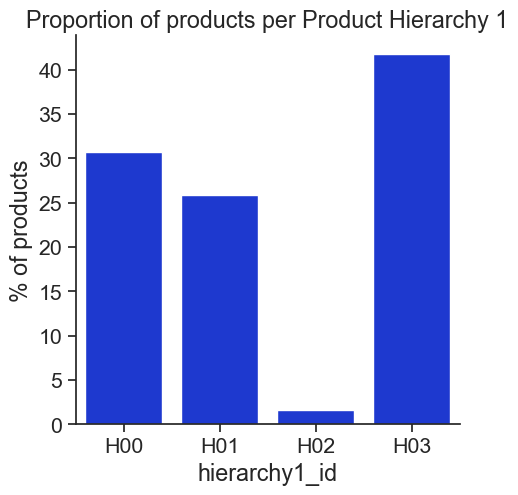

In [29]:
# Nº of products per category in hierarchy 
prod_h1 = products.groupby("hierarchy1_id")[
    "product_id"].count()/len(products) * 100

print(prod_h1)

# Visualization
sns.catplot(
    data = prod_h1, 
    kind = "bar")
plt.ylabel("% of products")
plt.title("Proportion of products per Product Hierarchy 1")
plt.show()

##### **Notes**

- Which hierarchy should be the most relevant to aggregate products?
- In hierarchy 1, the proportion of H02 is very low comparing to the others.

#### **Stores dataset**

##### **Inspect**

In [30]:
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   store_id      63 non-null     object
 1   storetype_id  63 non-null     object
 2   store_size    63 non-null     int32 
 3   city_name     63 non-null     object
dtypes: int32(1), object(3)
memory usage: 1.9+ KB


,store_id,storetype_id,store_size,city_name
0,S0002,ST04,39,Adana
1,S0003,ST03,17,Istanbul
2,S0005,ST04,19,Denizli
3,S0007,ST03,16,Istanbul
4,S0010,ST04,17,Istanbul


##### **store_id**

In [31]:
# Number of stores
stores["store_id"].nunique()

63

###### **Notes**

- There are 63 stores.

##### **storetype_id**

storetype_id
ST01     3.174603
ST02     1.587302
ST03    31.746032
ST04    63.492063
Name: store_id, dtype: float64


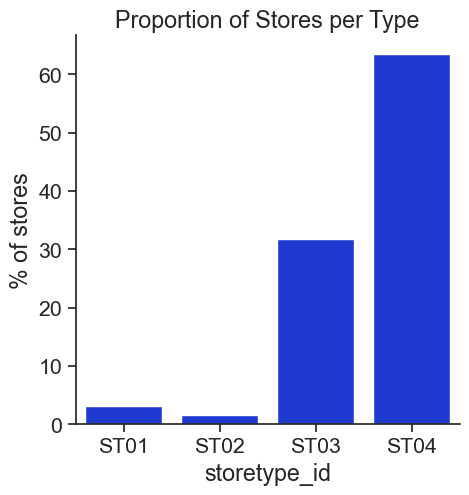

In [32]:
# Store types
stores["storetype_id"].unique()

# Nº of stores per type
store_type = stores.groupby(
    "storetype_id")["store_id"].count() / len(stores) * 100

print(store_type)

# Visualziation
sns.catplot(
    data = store_type,
    kind = "bar")
plt.ylabel("% of stores")
plt.title("Proportion of Stores per Type")
plt.show()

###### **Notes**

- There are 4 store types.
- The distribution of stores per type is very different.

##### **store_size**

count    63.000000
mean     24.809524
std      12.611895
min       8.000000
25%      15.500000
50%      20.000000
75%      31.500000
max      63.000000
Name: store_size, dtype: float64


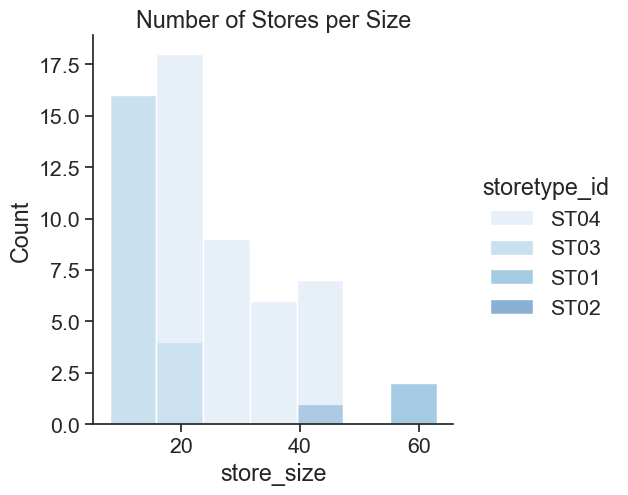

/tmp/ipykernel_53/1255659764.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(


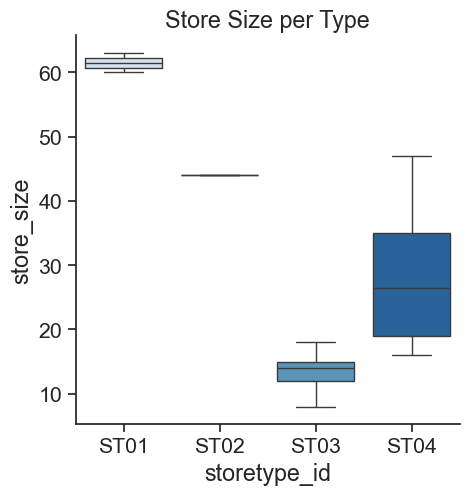

In [33]:
# Describe
print(stores["store_size"].describe())

# Visualization
sns.displot(
    data = stores,
    x = "store_size",
    hue = "storetype_id",
    kind = "hist",
    palette = "Blues")
plt.title("Number of Stores per Size")
plt.show()


sns.catplot(
    data = stores,
    y = "store_size",
    x = "storetype_id",
    kind = "box",
    palette = "Blues",
    order = ["ST01", "ST02", "ST03", "ST04"])
plt.title("Store Size per Type")
plt.show()

In [34]:
stores.groupby("storetype_id")["store_size"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
storetype_id,,,,,,,,
ST01,2.0,61.50,2.12,60.0,60.75,61.5,62.25,63.0
ST02,1.0,44.00,NaN,44.0,44.00,44.0,44.00,44.0
ST03,20.0,13.55,2.33,8.0,12.00,14.0,15.00,18.0
ST04,40.0,28.12,9.76,16.0,19.00,26.5,35.00,47.0


###### **Notes**

- The average store size is 24.81.
- What is the unit of measure?

##### **city_name**

In [35]:
# Number of cities
stores["city_name"].nunique()

19

/tmp/ipykernel_53/1531845449.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(


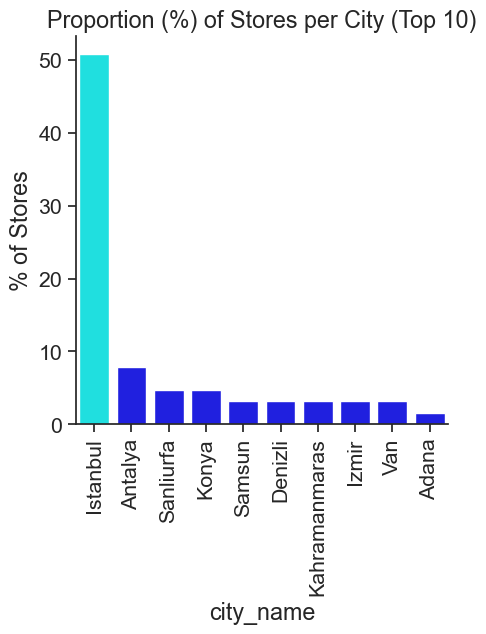

In [40]:
# Number of stores per city
store_city = (stores.groupby(
    "city_name")["store_id"].count() / len(stores) * 100).sort_values(ascending = False)

print(store_city.round(2))

# Visualization: Top 10
store_city_top10 = store_city.head(10)

sns.catplot(
    data = store_city_top10,
    kind = "bar", 
    palette = [insight_color] + ['blue'] * (len(store_city_top10) - 1))
plt.xticks(rotation = 90)
plt.ylabel("% of Stores")
plt.title("Proportion (%) of Stores per City (Top 10)")
plt.show()

###### **Notes**

- There are 19 cities.
- Around 51% of the stores are in Instanbul.